In [32]:
import bz2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
f = bz2.open("./DS-interview-challenge/data/geo_data.csv.bz2")
geo_data = pd.read_csv(f)
f2 = bz2.open("./DS-interview-challenge/data/mission_data.csv.bz2")
mission_data = pd.read_csv(f2)

In [264]:
df = pd.merge(mission_data, geo_data, how='left',on='robotid')
df.dropna(inplace=True)
new = df["timezone"].str.split("/", n = 1, expand = True)
df['area'] = new[0]
df.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,area
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Asia
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Asia
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Asia
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Asia
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Asia


#### Geographic Difference
The first question we are curious about is that is there any geographic difference in robot usage. To find out the answer, I first did a test on the 7 major areas `Asia, Europe, America, Australia, Pacific, Atlantic, Africa` that I filtered out from time zones, and to make the test simpler and more straightforward, I only test on missions with outcome `OK`.

I use ANOVA to test for differences overall between all groups(area) and since it's a parametric test, it has the following assumptions:
> 1. Independence: all groups are mutually exclusive 
> 2. Normality 
> 3. Equal Variance

My hypothesis are:
> $H_0$:There is no difference between average cleaning time among all area groups<br>
> $H_1$:At least one of the group means different

In [265]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_ok = df[df.outcome=='ok']
model = ols('runm ~ C(area)', data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(area),3.158713e+05,6.0,59.263453,1.063624e-73
Residual,3.265484e+08,367600.0,NaN,NaN


The test result gives p-value < 0.05, so we conclude that there is at least one group means different which means there is geographic difference in average running time among different area groups

- To further investigate geographic difference on the country level, I did some statistics and form tables below.

`uniq_robot`:number of robot in the country<br>
`avg_runm`:average running time of the country<br>
`avg_chrgm`:average charging time of the country<br>
`total_mssn`:total number of missions in the country<br>
`ok_mssn`:number of missions with outcome OK<br>
`stuck_mssn`:number of missions with outcome stuck<br>
`cncl_mssn`:number of missions with outcome cncl<br>
`bat_mssn`:number of missions with outcome bat<br>

In [148]:
usage = pd.DataFrame({'uniq_robot':df.groupby('country_cd').robotid.nunique(),
              'avg_runm': df.groupby('country_cd').runm.mean(),
              'avg_chrgm': df.groupby('country_cd').chrgm.mean(),
              'total_mssn': df.groupby('country_cd').nmssn.count(),
              'ok_mssn': df[df.outcome=='ok'].groupby('country_cd').nmssn.count(),
              'stuck_mssn': df[df.outcome=='stuck'].groupby('country_cd').nmssn.count(),
              'cncl_mssn': df[df.outcome=='cncl'].groupby('country_cd').nmssn.count(),
              'bat_mssn': df[df.outcome=='bat'].groupby('country_cd').nmssn.count()})

In [149]:
usage = usage.fillna(0)
usage = usage.rename(columns = {'index':'country_cd'})
usage['ok_rate'] = usage['ok_mssn']/usage['total_mssn']
usage['bat_rate'] = usage['bat_mssn']/usage['total_mssn']
usage['stuck_rate'] = usage['stuck_mssn']/usage['total_mssn']
usage.head()

,uniq_robot,avg_runm,avg_chrgm,total_mssn,ok_mssn,stuck_mssn,cncl_mssn,bat_mssn,ok_rate,bat_rate,stuck_rate
AD,1,40.020000,1.500000,50,36,0.0,14.0,0.0,0.720000,0.000000,0.000000
AE,5,50.623810,1.928571,210,136,6.0,63.0,5.0,0.647619,0.023810,0.028571
AG,1,51.625000,3.125000,8,3,1.0,3.0,1.0,0.375000,0.125000,0.125000
AR,16,49.242830,1.988528,523,318,26.0,170.0,9.0,0.608031,0.017208,0.049713
AT,285,47.184978,1.930100,10558,6512,775.0,3020.0,251.0,0.616783,0.023773,0.073404


In [267]:
# give statistics for each descriptive features
usage.describe()

,uniq_robot,avg_runm,avg_chrgm,total_mssn,ok_mssn,stuck_mssn,cncl_mssn,bat_mssn,ok_rate,bat_rate,stuck_rate
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,116.952381,47.179713,2.028229,4376.273810,2262.916667,264.750000,1745.226190,103.380952,0.622972,0.024408,0.065469
std,652.174470,4.608770,0.736154,24116.388011,10831.542500,1314.993617,11419.492159,598.732334,0.081782,0.021632,0.042018
min,1.000000,21.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000
25%,2.000000,45.259350,1.830282,75.250000,49.250000,3.000000,18.750000,1.000000,0.600000,0.014781,0.029202
50%,7.000000,47.404113,1.941622,233.500000,154.000000,18.000000,69.500000,5.000000,0.619636,0.022458,0.071955
75%,43.250000,49.327803,2.114591,1650.750000,996.750000,130.500000,475.000000,32.000000,0.648037,0.026316,0.086838
max,5956.000000,59.520000,7.200628,220119.000000,97966.000000,11965.000000,104712.000000,5476.000000,1.000000,0.125000,0.205882


In [150]:
usage[usage.uniq_robot>np.mean(usage.uniq_robot)]

,uniq_robot,avg_runm,avg_chrgm,total_mssn,ok_mssn,stuck_mssn,cncl_mssn,bat_mssn,ok_rate,bat_rate,stuck_rate
AT,285,47.184978,1.930100,10558,6512,775.0,3020.0,251.0,0.616783,0.023773,0.073404
BE,133,47.606090,2.094085,5123,3141,365.0,1501.0,116.0,0.613117,0.022643,0.071247
CA,277,47.812062,1.969081,11126,6903,856.0,3134.0,233.0,0.620439,0.020942,0.076937
CN,539,40.208891,1.905861,21054,13882,780.0,5946.0,446.0,0.659352,0.021184,0.037048
DE,208,47.309271,1.917190,8284,5097,542.0,2468.0,177.0,0.615282,0.021366,0.065427
FR,481,46.923811,3.176534,17719,11023,1398.0,4926.0,372.0,0.622101,0.020994,0.078898
IL,5956,50.555186,7.200628,220119,97966,11965.0,104712.0,5476.0,0.445059,0.024877,0.054357
JP,293,47.485821,1.977178,11743,7185,860.0,3434.0,264.0,0.611854,0.022481,0.073235
PL,119,47.620328,2.106427,4388,2678,353.0,1246.0,111.0,0.610301,0.025296,0.080447
US,237,47.559421,1.952074,8221,5182,560.0,2310.0,169.0,0.630337,0.020557,0.068118


#### Summary and Insights of all descriptive features
From above statistics, we take a look at countries with number of robots greater than the average value. 
- `Israel(IL)` has the most number of robots (5956) on record and the number is way larger than the rest of the other countries. It also has the longest average charging time (7.2), average cleaning time (50.5) and lowest OK_rate (0.44) among all the countreis. It might catch our attention on the battery life and navigating algorithms of the robot in this region and investigate the reason of the high cancel rate during robot's cleaning missions.<br><br>
- While IL has the longest average cleaning time, `China(CN)` has the shortest (40.2). Additionally, it has the lowest `stuck_rate` (0.037) compared to other countries which indicates an exceptional robot performance.<br><br>

So above all, we can conclude that there is geographic differences in robot usage. More specifically, they are different in overall robot number, average cleaning time, average charging time and different outcomes rate.

***
#### Investigate data loss
- To identify data loss, I exclude missing missions prior to the first record per robot, for example, if the first mission on record was 10, I assume missions 1-9 were missing due to disconnection of wifi. I am trying to identify data loss during mission reporting period <br><br>
- To help quantify the extend of the data loss, I define a function `countLoss` to count data loss for each robot, for example robot with mission number reporting `[10,11,13,14,17]` the function will return a number of 3 because mission 12, 15, 16 were missing.

In [161]:
def countLoss(l):
    return len(list(range(min(l), max(l)+1)))-len(l)

In [163]:
ids = mission_data['robotid'].drop_duplicates().to_list()

In [164]:
loss = []
for id in ids:
    l = mission_data[mission_data.robotid==id]['nmssn'].tolist()
    loss.append(countLoss(l))

In [261]:
len(loss),loss.count(0)

(9826, 1127)

In [279]:
from scipy import stats

stats.kstest(loss, stats.randint.cdf, args=(0,13))

KstestResult(statistic=0.16700590270710358, pvalue=1.8130792237687828e-238)

Among all the 9826 robots on file (mission_data), only 1127 has no data loss during mission reporting, which means about 89% of the robots has data loss. The KS test results suggest that the numbers of data loss are random. Then we check whether this data loss is uniform across all countries. Take US, CN and IL for example:

In [203]:
us_loss=[]
us_ids = df[df.country_cd=='US']['robotid'].drop_duplicates()
for id in us_ids:
    l = mission_data[mission_data.robotid==id]['nmssn'].tolist()
    us_loss.append(countLoss(l))

In [245]:
il_loss=[]
il_ids = df[df.country_cd=='IL']['robotid'].drop_duplicates()
for id in il_ids:
    l = mission_data[mission_data.robotid==id]['nmssn'].tolist()
    il_loss.append(countLoss(l))

In [255]:
cn_loss=[]
cn_ids = df[df.country_cd=='CN']['robotid'].drop_duplicates()
for id in cn_ids:
    l = mission_data[mission_data.robotid==id]['nmssn'].tolist()
    cn_loss.append(countLoss(l))

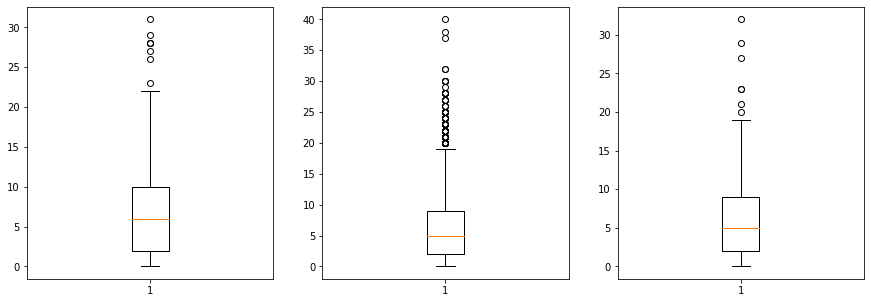

In [316]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.boxplot(cn_loss);
plt.subplot(1,3,2)
plt.boxplot(il_loss);
plt.subplot(1,3,3)
plt.boxplot(us_loss);

The boxplots above indicate similar level of data loss with mean number around 6